# Imports

In [2]:
# Specific to NERSC: Set up kernel using: https://docs.nersc.gov/services/jupyter/how-to-guides/
from __future__ import annotations

import sys

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# might have issues with too many files being opened at once
# this will prevent that
import torch.multiprocessing
import torch.nn.functional as f
from neuralop import H1Loss
from neuralop import LpLoss
from neuralop.data.datasets.darcy import DarcyDataset
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from neuralop.models import FNO
from neuralop.training import AdamW
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.utils import count_model_params
from neuralop.utils import get_project_root
from torch import nn
from torch.utils.data import DataLoader

from operator_aliasing.utils import get_energy_curve
from operator_aliasing.utils import get_model_preds

torch.multiprocessing.set_sharing_strategy('file_system')

root_dir = get_project_root() / 'neuralop/data/datasets/data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

FIG_DIR = '../figures'

device=device(type='cuda')


In [7]:
# install a filtering library and include a versioning work around
%pip install hdaf-filter==0.1.1

# Monkeypatch
from hdaf_filter import hdaf
from scipy.special import factorial

np.math = type('math', (), {})()
np.math.factorial = factorial

Note: you may need to restart the kernel to use updated packages.


# Get Data

In [8]:
# first download data
data = DarcyDataset(
    root_dir=root_dir,
    n_train=100,
    n_tests=[32, 32, 32, 32],
    batch_size=16,
    test_batch_sizes=[16, 16, 16, 16],
    train_resolution=128,  # change resolution to download different data
    test_resolutions=[16, 32, 64, 128],
)

# load darcy flow dataset


def load_darcy_flow_small(
    n_train,
    n_tests,
    data_root=root_dir,
    test_resolutions=(16, 32),
    train_resolution=16,
):
    """Docstring."""
    batch_size = 16
    test_batch_sizes = [batch_size] * len(test_resolutions)

    dataset = DarcyDataset(
        root_dir=data_root,
        n_train=n_train,
        n_tests=n_tests,
        batch_size=batch_size,
        test_batch_sizes=test_batch_sizes,
        train_resolution=train_resolution,
        test_resolutions=test_resolutions,
        encode_input=False,
        encode_output=True,
        channel_dim=1,
        encoding='channel-wise',
        download=True,
    )

    # return dataloaders for backwards compat
    train_loader = DataLoader(
        dataset.train_db,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        persistent_workers=False,
    )

    test_loaders = {}
    for res, test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(
            dataset.test_dbs[res],
            batch_size=test_bsize,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
            persistent_workers=False,
        )

    return train_loader, test_loaders, dataset.data_processor


train_resolution = 16
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=1000,
    # batch_size=16,
    train_resolution=train_resolution,
    test_resolutions=[16, 32, 64, 128],
    n_tests=[100, 100, 100, 100],
    # test_batch_sizes=[32, 32, 32, 32],
)

Loading test db for resolution 16 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 64 with 32 samples 
Loading test db for resolution 128 with 32 samples 
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 


In [10]:
for _idx, batch in enumerate(test_loaders[16]):
    low_res_batch = batch
    break

for _idx, batch in enumerate(test_loaders[128]):
    high_res_batch = batch
    break

# Train FNO at multiple resolutions

In [ ]:
"""
class NoAct(nn.Module):
    def __init__(self):
        super(NoAct, self).__init__()

    def forward(self, x):
        return x
"""

df = pd.DataFrame(
    columns=[
        'train_resolution',
        'test_resolution',
        'loss_type',
        'loss',
        'max_modes',
    ],
)
modes = {}
for max_modes in [16]:
    trained_models = {}  # at different resolutions
    for train_resolution in [16, 32, 64, 128]:
        # get data
        train_loader, test_loaders, output_encoder = load_darcy_flow_small(
            n_train=1000,
            # batch_size=16,
            train_resolution=train_resolution,
            test_resolutions=[16, 32, 64, 128],
            n_tests=[100, 100, 100, 100],
            # test_batch_sizes=[32, 32, 32, 32],
        )

        # incrementally vary modes
        incremental = True
        starting_modes = (max_modes, max_modes)
        if incremental:
            starting_modes = (2, 2)

        # Set up model
        model = FNO(
            max_n_modes=(max_modes, max_modes),
            n_modes=starting_modes,
            hidden_channels=32,
            in_channels=1,
            out_channels=1,
            # non_linearity=NoAct(),
        )
        model = model.to(device)
        n_params = count_model_params(model)

        # optimizer + data
        optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=30
        )

        data_transform = IncrementalDataProcessor(
            in_normalizer=None,
            out_normalizer=None,
            device=device,
            subsampling_rates=[2, 1],
            dataset_resolution=16,
            dataset_indices=[2, 3],
            epoch_gap=10,
            verbose=True,
        )

        data_transform = data_transform.to(device)

        l2loss = LpLoss(d=2, p=2)
        h1loss = H1Loss(d=2)
        train_loss = h1loss
        eval_losses = {'h1': h1loss, 'l2': l2loss}
        sys.stdout.flush()

        # Finally pass all of these to the Trainer
        trainer = IncrementalFNOTrainer(
            model=model,
            n_epochs=20,
            data_processor=data_transform,
            device=device,
            verbose=False,
            incremental_loss_gap=False,
            incremental_grad=True,
            incremental_grad_eps=0.9999,
            incremental_loss_eps=0.001,
            incremental_buffer=5,
            incremental_max_iter=1,
            incremental_grad_max_iter=2,
        )

        # train
        end_stats = trainer.train(
            train_loader,
            test_loaders,
            optimizer,
            scheduler,
            regularizer=False,
            training_loss=train_loss,
            eval_losses=eval_losses,
        )

        trained_models[train_resolution] = trainer.model

        # save stats
        for k, v in end_stats.items():
            s = k.split('_')

            if 'h1' in s or ('l2' in s):
                row = {
                    'train_resolution': train_resolution,
                    'test_resolution': s[0],
                    'loss_type': s[1],
                    'loss': v.item(),
                    'max_modes': max_modes,
                }
                df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

    modes[max_modes] = trained_models
    # Define colormap from green (high engagement) to red (low engagement)
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'green_red',
        ['green', 'yellow', 'red'],
        N=100,
    )
    for loss_type in ['l2', 'h1']:
        heat = df[
            (df.loss_type == loss_type) & (df.max_modes == max_modes)
        ].pivot(
            index='train_resolution',
            columns='test_resolution',
            values='loss',
        )
        heat = heat.loc[:, ['16', '32', '64', '128']]
        sns.heatmap(heat, cmap=cmap)
        plt.title(f'{loss_type=} {max_modes=}')
        plt.show()

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16


/tmp/ipykernel_2092808/218557674.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8


# Plot Spectrum

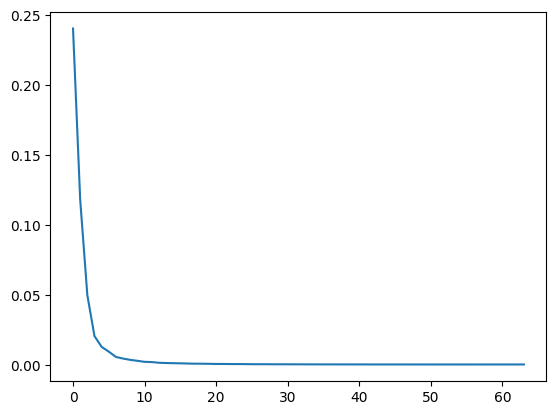

In [11]:
spectrum = get_energy_curve(high_res_batch['x'].squeeze())
plt.plot(spectrum)

In [ ]:
for spectrum_func in [get_energy_curve]:
    fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharey='row')

    model = model.to(device)
    model = model.eval()

    for idx, s in enumerate([16, 32, 64, 128]):
        ## Define some variables
        T = 500  # number of time steps
        samples = 50
        # s = 16 # resolution of the dataset

        # additional paramaters for the dataset
        Re = 5000
        index = 1
        T = 100
        dataset_name = 'Darcy Flow'

        train_loader, test_loaders, output_encoder = load_darcy_flow_small(
            n_train=1000,
            # batch_size=16,
            train_resolution=s,
            test_resolutions=[16, 32, 64, 128],
            n_tests=[100, 100, 100, 100],
            # test_batch_sizes=[32, 32, 32, 32],
        )

        # It is important to note that we want the last two dimensions
        # to represent the spatial dimensions
        # So in some cases one might have to permute the
        # dataset after squeezing
        # the initial dimensions as well

        # squeeze the dataset to remove the empty channel dimension
        dataset_pred = train_loader.dataset[:samples]['x'].squeeze()
        dataset_pred_y = train_loader.dataset[:samples]['y'].squeeze()
        model_preds_train = get_model_preds(
            train_loader, model, data_transform=data_transform
        ).squeeze()
        model_preds_test = get_model_preds(
            test_loaders[s], model, data_transform=data_transform
        ).squeeze()
        # Shape of the dataset
        shape = dataset_pred.shape

        # Generate the spectrum of the dataset
        # We reshape our samples into the form expected by ``spectrum_2d``:
        # ``(n_samples, h, w)``
        train_sp_x = spectrum_func(dataset_pred.reshape(samples * 1, s, s))
        train_sp_y = spectrum_func(dataset_pred_y.reshape(samples * 1, s, s))
        train_sp_model_pred = spectrum_func(
            model_preds_train[:samples].reshape(samples * 1, s, s)
        )

        test_sp_x = spectrum_func(
            test_loaders[s]
            .dataset[:samples]['x']
            .squeeze()
            .reshape(samples * 1, s, s)
        )
        test_sp_y = spectrum_func(
            test_loaders[s]
            .dataset[:samples]['y']
            .squeeze()
            .reshape(samples * 1, s, s)
        )
        test_sp_model_pred = spectrum_func(
            model_preds_test[:samples].reshape(samples * 1, s, s)
        )
        # Configure pyplot and generate the plot

        ax[idx].set_yscale('log')

        length = dataset_pred.shape[-1]  # the resolution length of the dataset
        buffer = 10  # just add a buffer to the plot
        k = np.arange(length + buffer) * 1.0
        ax[idx].plot(train_sp_x, linestyle=':', label='train_x')
        ax[idx].plot(train_sp_y, linestyle='-', label='train_y')
        ax[idx].plot(test_sp_x, linestyle=':', label='test_x')
        ax[idx].plot(test_sp_y, linestyle='-', label='test_y')
        ax[idx].plot(
            test_sp_model_pred, linestyle='-', label='test_model_pred'
        )
        ax[idx].plot(
            train_sp_model_pred, linestyle='-', label='train_model_pred'
        )

        ax[idx].set_title(f'Resolution: {s}')
        fig.suptitle(f'Spectrum of {dataset_name} Dataset')

    fig.supxlabel('wavenumber')
    fig.supylabel('energy')

    # show the figure
    leg = plt.legend(loc='best')
    leg.get_frame().set_alpha(0.5)
    plt.show()
    fig.savefig(
        f'{FIG_DIR}/{spectrum_func.__name__}_cross_resolution_spectral_analysis.pdf',
        bbox_inches='tight',
    )

# filter training experiment to test super-resolution

In [ ]:
data_transform = data_transform.to(device)
for _idx, sample in enumerate(test_loaders[16]):  # resolution 128
    model_input = data_transform.preprocess(sample)

    # grab a batch
    model_input = sample['x']  # [0, :, :, :].unsqueeze(dim=0)
    ground_truth = sample['y']  # [0, :, :, :].unsqueeze(dim=0)
    break

# grab image to initialize filter with
filter_initializer_img = model_input[0, 0, :, :].cpu().numpy()

In [ ]:
def show_img_and_power_spectrum(image: np.array):
    """Show image and its corresponding energy spectrum."""
    fig, axs = plt.subplots(1, 2, figsize=(5, 2))

    axs[0].imshow(image)
    axs[0].set_title('Spatial Domain')

    spectrum = spectrum_func(torch.tensor(image).unsqueeze(dim=0))
    axs[1].plot(spectrum)
    axs[1].set_title('spectrum')
    axs[1].set_ylabel('Energy')
    axs[1].set_xlabel('Wavenumber')
    # axs[1].set_xscale("log")

    plt.tight_layout()
    plt.show()


show_img_and_power_spectrum(filter_initializer_img)

In [ ]:
show_img_and_power_spectrum(filter_initializer_img)
show_img_and_power_spectrum(ground_truth[0, 0, :, :].cpu())

# initialize filter
filter_obj = hdaf.filt(filter_initializer_img)

low_freq_limit = 3
low_pass_filter = filter_obj.get_filter('low_pass', low_freq_limit)
plt.imshow(low_pass_filter[0])
plt.show()
low_pass_filter = torch.tensor(low_pass_filter, device=device)

# fft batch
batch_fourier = torch.fft.fftn(ground_truth, dim=(-2, -1))

# center batch, filter
filter_centered = torch.fft.fftshift(low_pass_filter)
fourier_centered = torch.fft.fftshift(batch_fourier)

# apply filter
filtered_batch = fourier_centered * filter_centered

# visualize a filtered image in FFT space
plt.imshow(np.log(np.abs(1 + filtered_batch[0, 0, :, :].cpu())))
plt.show()

# convert batch back to spatial domain
batch = torch.real(
    torch.fft.ifftn(torch.fft.ifftshift(filtered_batch), dim=(-1, -2))
)
show_img_and_power_spectrum(batch[0, 0, :, :].cpu())

# show diff from original and filtered

show_img_and_power_spectrum(
    ground_truth[0, 0, :, :].cpu() - batch[0, 0, :, :].cpu()
)

# Playing w/ spectral conv layer

In [6]:
in_channels = 1
out_channels = 1
modes1 = 8
modes2 = 8

In [1]:
"""
class SpectralConv2d(nn.Module):
    def __init__(
        self,
        in_channels,  # Number of input channels
        out_channels,  # Number of output channels
        modes1,  # Number of Fourier modes to multiply in the first dimension
        modes2,
    ):  # Number of Fourier modes to multiply in the second dimension
        super(SpectralConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(
                in_channels,
                out_channels,
                self.modes1,
                self.modes2,
                dtype=torch.cfloat,
            )
        )
        self.weights2 = nn.Parameter(
            self.scale
            * torch.rand(
                in_channels,
                out_channels,
                self.modes1,
                self.modes2,
                dtype=torch.cfloat,
            )
        )

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-2),
            x.size(-1) // 2 + 1,
            dtype=torch.cfloat,
            device=x.device,
        )
        out_ft[:, :, : self.modes1, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, : self.modes1, : self.modes2], self.weights1
        )
        out_ft[:, :, -self.modes1 :, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, -self.modes1 :, : self.modes2], self.weights2
        )

        # Return to physical space
        print(f'{out_ft.shape=}, {(x.size(-2), x.size(-1))=}')
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) 
        # -> (batch, out_channel, x,y)
        print(f'{input.shape=}')
        return torch.einsum('bixy,ioxy->boxy', input, weights)



spectral_conv = SpectralConv2d(
    in_channels=in_channels,
    out_channels=out_channels,
    modes1=modes1,
    modes2=modes2,
)
spectral_conv.forward(low_res_batch['x']).shape
spectral_conv.forward(high_res_batch['x']).shape
"""

"\nclass SpectralConv2d(nn.Module):\n    def __init__(\n        self,\n        in_channels,  # Number of input channels\n        out_channels,  # Number of output channels\n        modes1,  # Number of Fourier modes to multiply in the first dimension\n        modes2,\n    ):  # Number of Fourier modes to multiply in the second dimension\n        super(SpectralConv2d, self).__init__()\n\n        self.in_channels = in_channels\n        self.out_channels = out_channels\n        self.modes1 = modes1\n        self.modes2 = modes2\n\n        self.scale = 1 / (in_channels * out_channels)\n        self.weights1 = nn.Parameter(\n            self.scale\n            * torch.rand(\n                in_channels,\n                out_channels,\n                self.modes1,\n                self.modes2,\n                dtype=torch.cfloat,\n            )\n        )\n        self.weights2 = nn.Parameter(\n            self.scale\n            * torch.rand(\n                in_channels,\n                o

In [ ]:
from neuralop.layers.spectral_convolution import SpectralConv

modes1 = 400
modes2 = 400
fourier_layer = SpectralConv(
    in_channels=in_channels,
    out_channels=out_channels,
    n_modes=(modes1, modes2),
)
fourier_layer.forward(high_res_batch['x']).shape

In [ ]:
max_modes = 400
starting_modes = (max_modes, max_modes)
model = FNO(
    max_n_modes=(max_modes, max_modes),
    n_modes=starting_modes,
    hidden_channels=32,
    in_channels=1,
    out_channels=1,
)
model(high_res_batch['x']).shape

# Testing Activation Functions

- try style gan activation function (CNO), and see what happens

- https://github.com/camlab-ethz/AI_Science_Engineering/blob/main/Tutorial%2006%20-%20Operator%20Learing%20-%20Convolutional%20Neural%20Operator.ipynb 

In [5]:
class CNOLReLu(nn.Module):
    """Same activation function as StyleGAN3: meant to prevent aliasing."""

    def __init__(self, in_size, out_size):
        """Initilize StyleGan Relu."""
        super(__class__, self).__init__()

        self.in_size = in_size
        self.out_size = out_size
        self.act = nn.LeakyReLU()

    def forward(self, x):
        """Upsample, activation, downsample."""
        x = f.interpolate(
            x.unsqueeze(2),
            size=(1, 2 * self.in_size),
            mode='bicubic',
            antialias=True,
        )
        x = self.act(x)
        x = f.interpolate(
            x, size=(1, self.out_size), mode='bicubic', antialias=True
        )

        return x[:, :, 0]

In [ ]:
max_modes = 16
starting_modes = (max_modes, max_modes)
model = FNO(
    max_n_modes=(max_modes, max_modes),
    n_modes=starting_modes,
    hidden_channels=32,
    in_channels=1,
    out_channels=1,
    # non_linearity=NoAct(),
)

model(high_res_batch['x'])

In [ ]:
model.fno_blocks.convs[0](high_res_batch['x']).shape